# DMD implementation notebook

Data is already preprocessed so can load in directly

In [3]:
from wfdb.io import rdrecord
from wfdb import Record
import wfdb.processing as wd
from denoising import denoise
import os
import numpy as np


In [5]:


import pandas as pd


base_path = "physionet-data/processed1"
recordPath = []


for root, dirs, files in os.walk(base_path):

    files.sort()

    for file in files:
        if file.endswith(".dat"):

            record_name = os.path.splitext(file)[0]

            record_path = os.path.join(root, record_name)


            recordPath.append(record_path)

records:list[Record] = []
sf = 0
for r in recordPath:
    record = rdrecord(
r
    )
    if sf == 0:
        sf = record.fs
    elif sf != record.fs:
        raise ValueError("Sampling frequency of signals do not match")
    records.append(record)


#loading signal data to data frame for easy manipulation
signalsDf:list[pd.DataFrame]=[]
for s in records:
    signalsDf.append(s.to_dataframe())

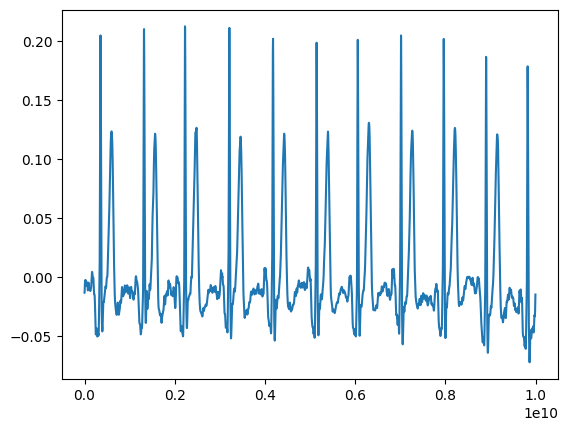

In [8]:
import matplotlib.pyplot as plt

plt.plot(signalsDf[0]["II"])


In [ ]:

peaks=wd.xqrs_detect(signalsDf[0]['II'][:2000].to_numpy(),sf)




x_values = signalsDf[0].index[:2000].total_seconds()  


plt.plot(x_values, signalsDf[0]['II'][:2000], label='Signal II')


plt.scatter(x=x_values[peaks], y=signalsDf[0]['II'].iloc[peaks], color='red', label='Peaks')


plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()

# Show plot
plt.show()


In [ ]:
peak=peaks[2]

beat=signalsDf[0]['II'].iloc[peak-125:peak+200]



plt.plot(beat)

In [ ]:


old=pd.DataFrame(signalsDf[0][:2000].to_numpy())
old=old.T
old

In [24]:
def AugMat(signal:np.ndarray,h):

    n,m=signal.shape

    aug=None
    for i in range (n):
        for x in range(h):
            row=signal[i][x:m-h+x]
            if aug is None:
                aug=row
            else:
                aug=np.vstack((aug,row))
        
            

    return aug

    




In [26]:
def AugMat2(signal: np.ndarray, h: int):
    n, m = signal.shape
    aug = []
    for i in range(n):
        for x in range(h):
            row = signal[i][x:m-h+x]
            aug.append(row)
    return np.vstack(aug)

In [27]:
AugMat2(signalsDf[0].to_numpy().T,300)

array([[-0.0131359 , -0.01136483, -0.00844227, ..., -0.02644702,
        -0.0255083 , -0.02388743],
       [-0.01136483, -0.00844227, -0.00449962, ..., -0.0255083 ,
        -0.02388743, -0.02178468],
       [-0.00844227, -0.00449962, -0.00250953, ..., -0.02388743,
        -0.02178468, -0.01944413],
       ...,
       [ 0.18353695,  0.18407342,  0.18396613, ..., -0.0243879 ,
        -0.02164118, -0.0191305 ],
       [ 0.18407342,  0.18396613,  0.18323653, ..., -0.02164118,
        -0.0191305 , -0.01699535],
       [ 0.18396613,  0.18323653,  0.181949  , ..., -0.0191305 ,
        -0.01699535, -0.01531084]])

In [ ]:
new=pd.DataFrame(AugMat(old.to_numpy(),300))
new

In [ ]:
newT=new.T
oldT=old.T

In [ ]:

# Plot old[0] with a specific color and label
plt.plot(oldT[0], color='blue', label='Old Data')

# Plot new[0] with a different color and label
plt.plot(newT[10], color='red', label='New Data')

# Add a legend to distinguish the lines
plt.legend()

# Add title and axis labels if needed
plt.title('Comparison of Old and New Data')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# Show the plot
plt.show()

In [ ]:
import pydmd as dmd



DMD=dmd.DMD(svd_rank=100)

DMD.fit(new.to_numpy())

In [ ]:
from pydmd.plotter import plot_summary

plot_summary(
    DMD, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
    figsize=(12, 7),
    index_modes=(0,7, 9),
    order="F",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=100,
)

In [ ]:
test=signalsDf[22][:2000].to_numpy().T

In [ ]:
test=AugMat(test,300)


In [ ]:
DMD2=dmd.DMD(svd_rank=100)

DMD2.fit(test)

In [ ]:
plot_summary(
    DMD2, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
    figsize=(12, 7),
    index_modes=(0, 1,6),
    order="F",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=100,
)

In [ ]:
beat=oldT[peak-125:peak+200]

beat=beat.T

beat=AugMat(beat.to_numpy(),60)




In [ ]:
DMDbeat=dmd.DMD(svd_rank=100)
DMDbeat.fit(beat)


In [ ]:
plot_summary(
    DMDbeat, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
    figsize=(12, 7),
    index_modes=(0, 2, 4),
    order="F",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=100,
)

In [ ]:
b=DMD.predict(new.to_numpy())
for _ in range(200):
    b=DMD.predict(b)

In [ ]:


plt.plot(newT[799],color='blue',label='Original')
plt.plot(b[598],color='red', label='DMD predicted')
plt.title('Predicted Wave by DMD')
plt.legend()
plt.show()

In [ ]:
Modes=DMD.modes
eig=DMD.eigs


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming Modes is already defined
n_modes = Modes.shape[0]  # Number of rows in Modes
length = Modes.shape[1]   # Length of each mode

# Define the step size for skipping frames
step_size = int(n_modes / 30)  # This will create approximately 50 frames

# Create a list of frames with skips
frame_indices = np.arange(0, n_modes, step_size)

# Create the figure and axis for the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Set up the plot limits based on the entire Modes array
ax.set_xlim(0, length - 1)
ax.set_ylim(np.min(Modes), np.max(Modes))

# Initialization function to set the background of each frame
def init():
    line.set_data([], [])
    return line,

# Update function that will be called for each frame
def update(frame):
    mode_index = frame_indices[frame]  # Get the mode index to display
    
    x = np.arange(length)
    y = Modes[mode_index]
    
    line.set_data(x, y)
    ax.set_title(f"Mode {mode_index + 1}/{n_modes}")
    
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(frame_indices), init_func=init, blit=False, repeat=False, interval=200)  # 200ms (0.2 sec) per frame

# Display the animation
ani.save('animation.html', writer='html')


In [ ]:
nModes=int(Modes.shape[0]/12)

restacked= Modes.reshape(12, 300, -1).mean(axis=1)


In [ ]:
Modes_restacked = np.zeros((12,Modes.shape[1]))

for j in range(nModes):
    Modes_restacked = Modes_restacked + Modes[int(j*12):int(j*12 + 12),:]

Modes_restacked = Modes_restacked/nModes

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))


ax1.plot(Modes)
ax1.set_title('Augumented')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')


ax2.plot(Modes_restacked)
ax2.set_title('Restacked')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')

# Adjust layout
plt.tight_layout()

In [ ]:
Modes_restacked.shape

In [ ]:
plt.plot(Modes_restacked)

In [ ]:
Lambda_ind_u = np.where(np.abs(eig) > 1)
Lambda_ind_s = np.where(np.abs(eig) < 1)

Lambda_u = eig[Lambda_ind_u] #unstable eigen values
Lambda_s = eig[Lambda_ind_s] #stable eigen values

Pho_u = Modes_restacked[:,Lambda_ind_u].reshape((12,Lambda_u.shape[0])) #unstable modes
Pho_s = Modes_restacked[:,Lambda_ind_s].reshape((12,Lambda_s.shape[0])) #stable modes

numS=Lambda_s.shape[0]
numU=Lambda_u.shape[0]


In [ ]:
Lambda_ind_u = np.where(np.abs(eig) > 1)
Lambda_ind_s = np.where(np.abs(eig) < 1)

Lambda_u = eig[Lambda_ind_u] #unstable eigen values
Lambda_s = eig[Lambda_ind_s] #stable eigen values

Pho_u2 = restacked[:,Lambda_ind_u].reshape((12,Lambda_u.shape[0])) #unstable modes
Pho_s2 = restacked[:,Lambda_ind_s].reshape((12,Lambda_s.shape[0])) #stable modes

numS=Lambda_s.shape[0]
numU=Lambda_u.shape[0]


In [ ]:
R_N=(numU)/(numU+numS)

R_N




In [ ]:
R_M = np.sum(np.sum(np.abs(Pho_u), axis = 1))/(np.sum(np.sum(np.abs(Pho_u), axis = 1)) + np.sum(np.sum(np.abs(Pho_s), axis = 1)))
R_P = np.sum(np.sum(np.angle(Pho_u), axis = 1))/(np.sum(np.sum(np.angle(Pho_u), axis = 1)) +  np.sum(np.sum(np.angle(Pho_s), axis = 1)))
print(R_M,R_P)

In [ ]:
R_M = np.sum(np.sum(np.abs(Pho_u2), axis = 1))/(np.sum(np.sum(np.abs(Pho_u2), axis = 1)) + np.sum(np.sum(np.abs(Pho_s2), axis = 1)))
R_P = np.sum(np.sum(np.angle(Pho_u2), axis = 1))/(np.sum(np.sum(np.angle(Pho_u2), axis = 1)) +  np.sum(np.sum(np.angle(Pho_s2), axis = 1)))
print(R_M,R_P)

In [ ]:

Lam_min = np.min(np.abs(Lambda_s),initial = -1 )
Lam_max = np.max(np.abs(Lambda_u), initial = -1 )

In [165]:
M_s = np.sum(np.abs(Pho_s), axis=1)/numS
P_s = np.sum(np.angle(Pho_s), axis=1) / numS


# np.sum(np.angle(Pho_s),axis=1)/numS
# np.sum(np.angle(Pho_s2),axis=1)/numS
P_s

array([0.00932223, 0.00932223, 0.00932223, 0.00932223, 0.00932223,
       0.00932223, 0.00932223, 0.00932223, 0.00932223, 0.00932223,
       0.00932223, 0.00932223])

In [167]:

M_u = np.sum(np.abs(Pho_u), axis=1)/numU 
P_u = np.sum(np.angle(Pho_u-np.angle(Pho_u[0])), axis=1)/numU
M_u

array([0.00024789, 0.00024789, 0.00024792, 0.00024789, 0.00024773,
       0.00024751, 0.00024724, 0.00024695, 0.00024671, 0.00024659,
       0.0002466 , 0.00024673])

In [ ]:
test2=signalsDf[23][:2000].to_numpy().T
test2=AugMat2(test2,300)

In [ ]:
DMDTest=dmd.DMD()
DMDTest.fit(test2)


In [ ]:
plot_summary(
    DMDTest, # <-- Fitted PyDMD model. Can be DMD, BOPDMD, etc.
    figsize=(12, 7),
    index_modes=(0, 2, 4),
    order="F",
    mode_cmap="seismic",
    dynamics_color="k",
    flip_continuous_axes=True,
    max_sval_plot=429,
)

In [ ]:
testModes=DMDTest.modes
testEigs=DMDTest.eigs


In [ ]:
testModes=testModes.reshape(12, 300, -1).mean(axis=1)




In [ ]:
Lambda_testind_u = np.where(np.abs(testEigs) > 1)
Lambda_testind_s = np.where(np.abs(testEigs) < 1)

LambdaTestU = testEigs[Lambda_testind_u] #unstable eigen values
LambdaTestS = testEigs[Lambda_testind_s] #stable eigen values

PhoTestU = testModes[:,Lambda_testind_u].reshape((12,LambdaTestU.shape[0])) #unstable modes
PhoTestS = testModes[:,Lambda_testind_s].reshape((12,LambdaTestS.shape[0])) #stable modes

numS=LambdaTestS.shape[0]
numU=LambdaTestU.shape[0]



In [168]:
RN=numU/(numS+numU)
RN

0.21445221445221446

In [187]:
R_M = np.sum(np.sum(np.abs(PhoTestU), axis = 1))/(np.sum(np.sum(np.abs(PhoTestU), axis = 1)) + np.sum(np.sum(np.abs(PhoTestS), axis = 1)))

R_P=np.sum(np.sum(np.mean([np.angle(PhoTestU[x]) - np.angle(PhoTestU[0]) for x in range(0, 12)])))

print(R_M,R_P)


0.28726403923222016 0.0


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([-0.24488476,  0.24488476,  0.53672039, -0.53672039, -4.16316765,
         4.16316765,  3.39399965, -3.39399965,  1.67110469, -1.67110469,
        -3.39989238,  3.39989238,  2.87120407, -2.87120407,  2.38406916,
        -2.38406916,  3.19687374, -3.19687374, -3.62698683,  3.62698683,
         2.71070648, -2.71070648,  2.72556763, -2.72556763,  2.52533529,
        -2.52533529,  2.56515412, -2.56515412, -3.78429911,  3.78429911,
         2.34991554, -2.34991554, -3.99610543,  3.99610543, -3.977656  ,
         3.977656  ,  2.38343384, -2.38343384, -3.54613914,  3.54613914